In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [7]:
df = df = pd.read_csv('https://raw.githubusercontent.com/sainihimanshu1999/Machine_Learning/main/Time%20Series%20-%20XgBoost/PJME_hourly.csv')

In [8]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [9]:
df = df.set_index('Datetime')
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


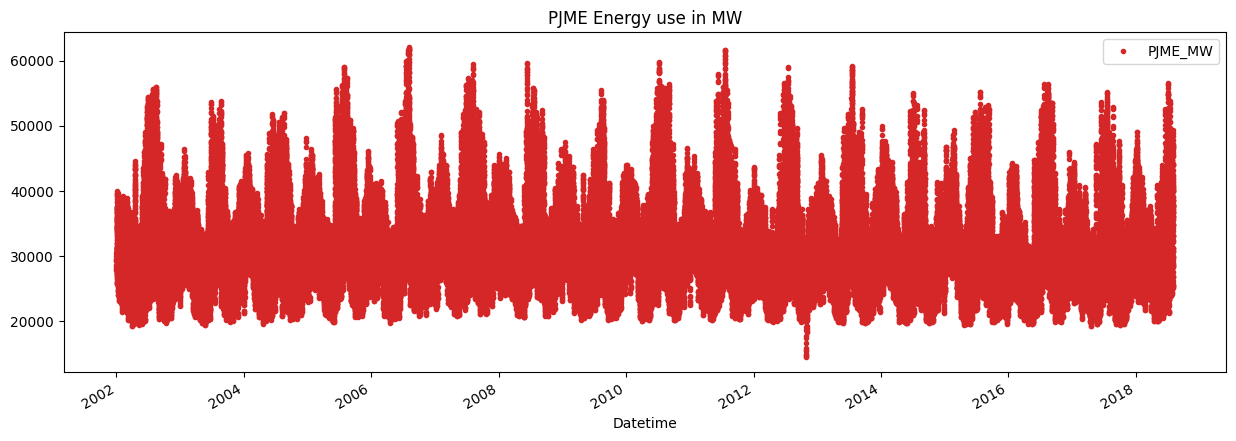

In [16]:
df.plot(style='.',
        figsize=(15,5),
        color = color_pal[3],
        title = 'PJME Energy use in MW')

plt.show()

<Axes: ylabel='Frequency'>

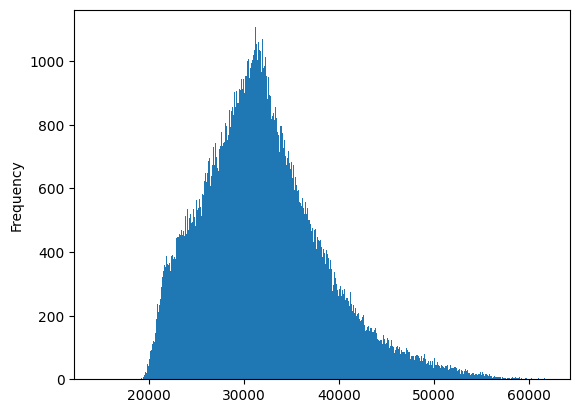

In [14]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

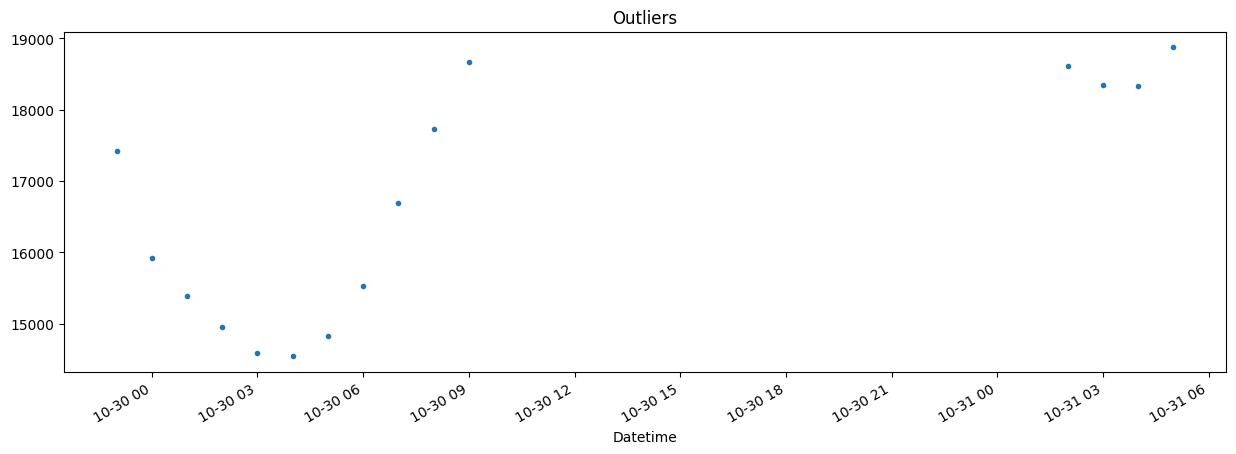

In [20]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.', figsize=(15,5), color=color_pal[0],title='Outliers')

In [21]:
df = df.query('PJME_MW > 19_000').copy()

<Axes: title={'center': 'PJME energy consumption'}, xlabel='Datetime'>

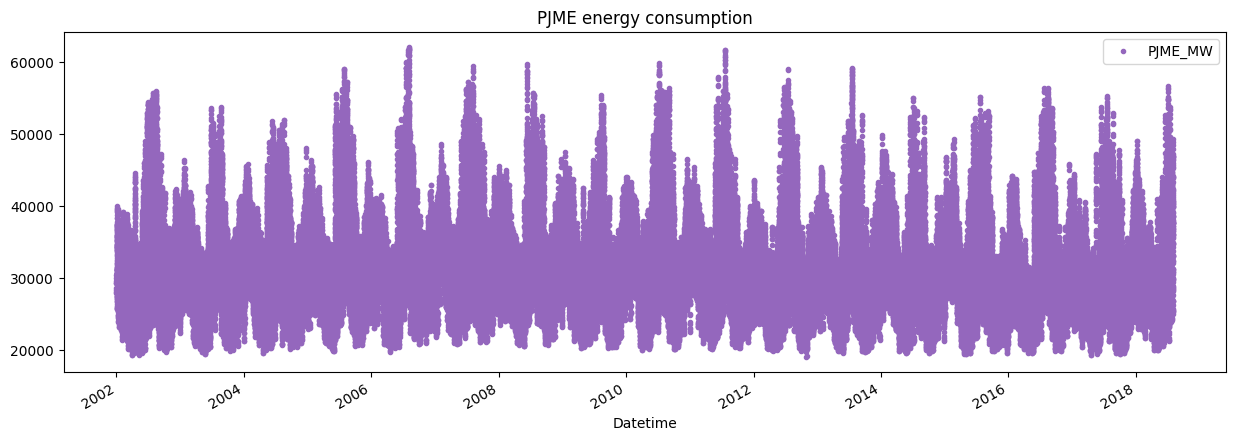

In [23]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[4],
        title='PJME energy consumption')

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1 , gap=24)


In [25]:
df = df.sort_index()

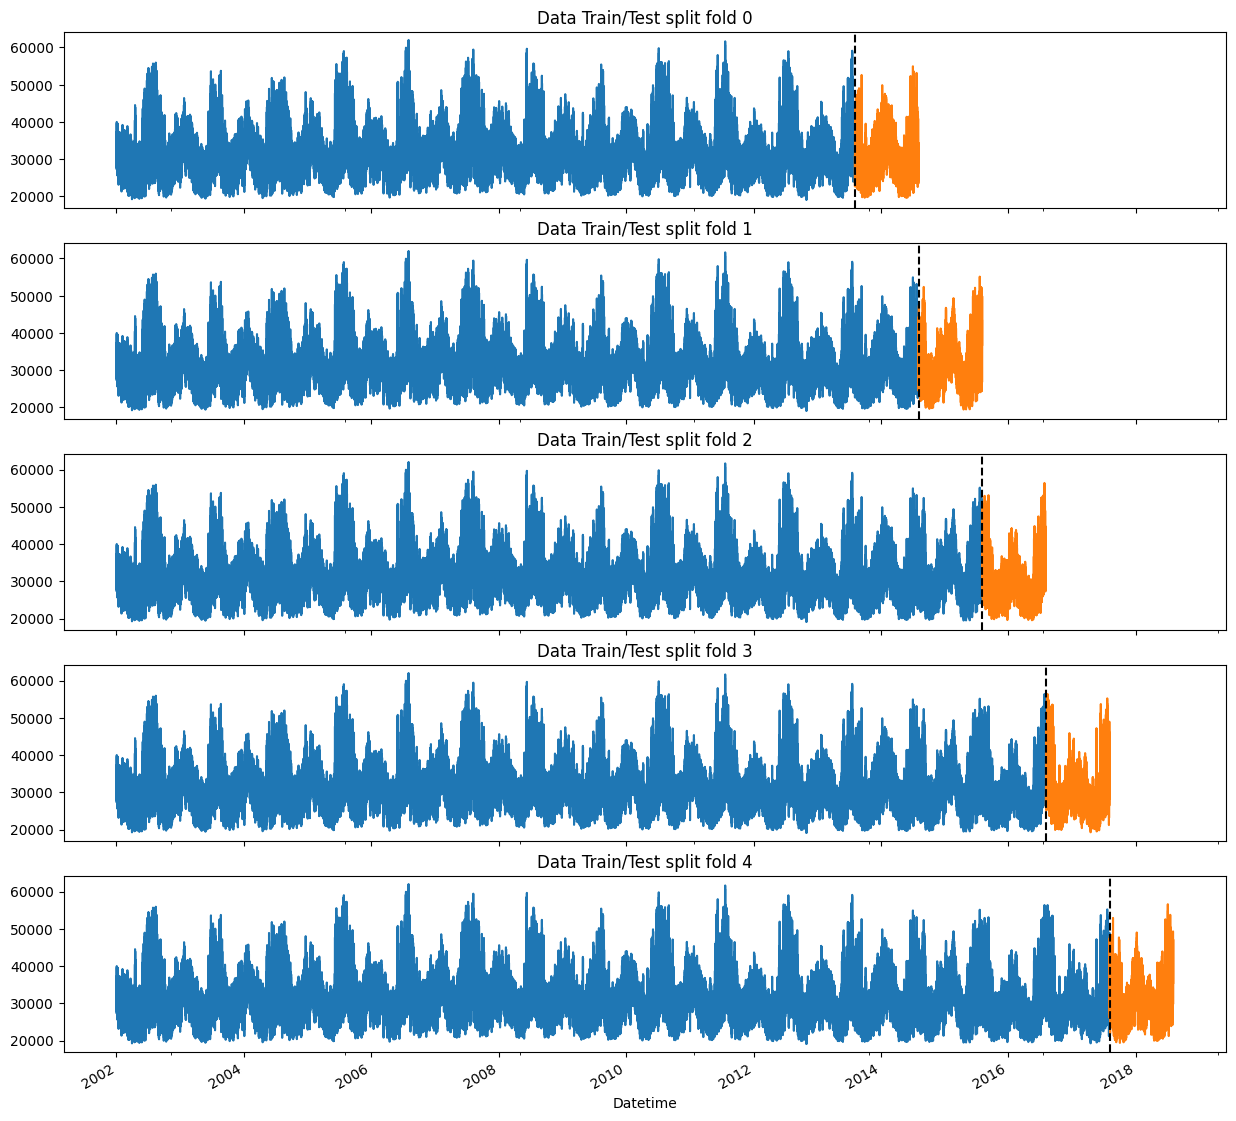

In [30]:
fig,axs = plt.subplots(5,1, figsize = (15,15), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]
  train['PJME_MW'].plot(ax = axs[fold],
                        label = 'Training Set',
                        title = f'Data Train/Test split fold {fold}')

  test['PJME_MW'].plot(ax = axs[fold], label = 'Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold+=1

In [31]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

In [32]:
df = create_features(df)

In [33]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1


In [34]:
target_map = df['PJME_MW'].to_dict()
target_map

{Timestamp('2002-01-01 01:00:00'): 30393.0,
 Timestamp('2002-01-01 02:00:00'): 29265.0,
 Timestamp('2002-01-01 03:00:00'): 28357.0,
 Timestamp('2002-01-01 04:00:00'): 27899.0,
 Timestamp('2002-01-01 05:00:00'): 28057.0,
 Timestamp('2002-01-01 06:00:00'): 28654.0,
 Timestamp('2002-01-01 07:00:00'): 29308.0,
 Timestamp('2002-01-01 08:00:00'): 29595.0,
 Timestamp('2002-01-01 09:00:00'): 29943.0,
 Timestamp('2002-01-01 10:00:00'): 30692.0,
 Timestamp('2002-01-01 11:00:00'): 31395.0,
 Timestamp('2002-01-01 12:00:00'): 31496.0,
 Timestamp('2002-01-01 13:00:00'): 31031.0,
 Timestamp('2002-01-01 14:00:00'): 30360.0,
 Timestamp('2002-01-01 15:00:00'): 29798.0,
 Timestamp('2002-01-01 16:00:00'): 29720.0,
 Timestamp('2002-01-01 17:00:00'): 31271.0,
 Timestamp('2002-01-01 18:00:00'): 35103.0,
 Timestamp('2002-01-01 19:00:00'): 35732.0,
 Timestamp('2002-01-01 20:00:00'): 35639.0,
 Timestamp('2002-01-01 21:00:00'): 35285.0,
 Timestamp('2002-01-01 22:00:00'): 34007.0,
 Timestamp('2002-01-01 23:00:00'

In [35]:
df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

In [37]:
df.tail(100)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-07-29 21:00:00,37870.0,21,6,3,7,2018,210,29,30,34162.0,42201.0,40339.0
2018-07-29 22:00:00,36581.0,22,6,3,7,2018,210,29,30,33160.0,40965.0,39057.0
2018-07-29 23:00:00,33747.0,23,6,3,7,2018,210,29,30,30724.0,38237.0,36074.0
2018-07-30 00:00:00,30789.0,0,0,3,7,2018,211,30,31,28047.0,35244.0,32928.0
2018-07-30 01:00:00,28389.0,1,0,3,7,2018,211,30,31,25836.0,32681.0,30290.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


In [49]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx,val_idx in tss.split(df):
  train = df.iloc[train_idx]
  test = df.iloc[val_idx]

  train = create_features(train)
  test = create_features(test)

  Features = ['dayofyear','hour','dayofweek','quarter','month','year',
              'lag1','lag2','lag3']
  Target = 'PJME_MW'

  X_train = train[Features]
  X_test = test[Features]

  y_train = train[Target]
  y_test = test[Target]

  reg = xgb.XGBRegressor(base_score=0.5, booster = 'gbtree', n_estimators=1000, early_stopping_rounds = 50,
                         objective = 'reg:linear',
                         max_depth=3,
                         eta=0.01)

  reg.fit(X_train,y_train,
          eval_set=[(X_train,y_train), (X_test, y_test)],
          verbose=100)


  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)


[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:00:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:00:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:01:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:01:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:01:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [50]:
print(f'score across folds {np.mean(scores):0.4f}')
print(f'Fold Scores:{scores}')

score across folds 3742.5833
Fold Scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


In [51]:
df = create_features(df)

Features = ['dayofyear','hour','dayofweek','quarter','month','year',
              'lag1','lag2','lag3']
Target = 'PJME_MW'

X_all = df[Features]
y_all = df[Target]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster = 'gbtree',
                       n_estimators = 500,
                       objective = 'reg:linear',
                       max_depth = 3,
                       eta=0.01)

reg.fit(X_all,y_all, eval_set = [(X_all,y_all)],verbose=100)



[0]	validation_0-rmse:32403.88991


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:08:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)